In [71]:
import librosa
import librosa.display
import cv2
import numpy as np
import matplotlib.pyplot as plt
cv2.__version__

'4.5.5'

In [72]:
librosa.__version__

'0.9.1'

In [73]:
y, sr = librosa.load(librosa.ex('trumpet'))
print(y.shape, sr)

(117601,) 22050


In [86]:
onset_env = librosa.onset.onset_strength(y=y, sr=sr)

# Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
print('Estimated tempo: {:.2f} beats per minute'.format(tempo))
print(beat_frames.shape)

# dynamic tempo
dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr,
                            aggregate=None)

# Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
print(beat_times.shape)
print(dtempo.shape)

Estimated tempo: 184.57 beats per minute
(4,)
(4,)
(230,)


In [66]:
hop_len = 512
freq_w = 3
octave = 8

C = librosa.cqt(y, sr=sr, hop_length= hop_len, n_bins= 12*freq_w*octave, bins_per_octave= 12*freq_w)
C

array([[ 8.7092158e-05+1.0339984e-04j,  1.1144641e-04-7.9894460e-05j,
        -7.1949595e-05-1.1883960e-04j, ...,
        -2.1236959e-09-1.2005826e-10j, -2.8109107e-10+2.0165607e-09j,
         1.8462669e-09+3.2992636e-10j],
       [ 1.3038056e-04+1.2820076e-04j,  1.4628386e-04-1.0744146e-04j,
        -8.1683291e-05-1.5929753e-04j, ...,
        -1.2505208e-09-3.6177668e-11j, -1.7153848e-10+1.3790952e-09j,
         1.4304550e-09+3.8208398e-10j],
       [ 2.0834025e-04+1.3416205e-04j,  1.8706726e-04-1.6863964e-04j,
        -1.1480207e-04-2.2764542e-04j, ...,
        -1.6994230e-09+1.2186054e-09j,  6.8374861e-10+2.0436364e-09j,
         2.1769360e-09+1.0882116e-11j],
       ...,
       [ 1.2134794e-03+5.6015182e-04j, -1.0657584e-03-6.3301843e-05j,
        -2.9847012e-03+7.2249240e-04j, ...,
         2.0347272e-05-1.3640551e-05j,  3.6076849e-06+2.6406813e-06j,
        -1.6322978e-05+1.7644832e-06j],
       [ 9.8200282e-04-9.1201370e-04j, -7.7462447e-04-2.7500986e-05j,
        -2.7306483e-03

In [67]:
C_db = librosa.amplitude_to_db(np.abs(C), ref=np.max)+80
c_compression = C_db/80*255
print(c_compression.max())

c_stretching_pre = np.where(c_compression<150,0,c_compression)
print(c_stretching_pre.min(), c_stretching_pre.max())

c_stretching = np.where((c_stretching_pre-155)/100*255<0,0,(c_stretching_pre-155)/100*255)
print(c_stretching.min(), c_stretching.max())

c_gray = c_stretching.astype(np.uint8)
print(c_gray.max(),c_gray.min())

255.0
0.0 255.0
0.0 255.0
255 0


ValueError: x and y must be the same size

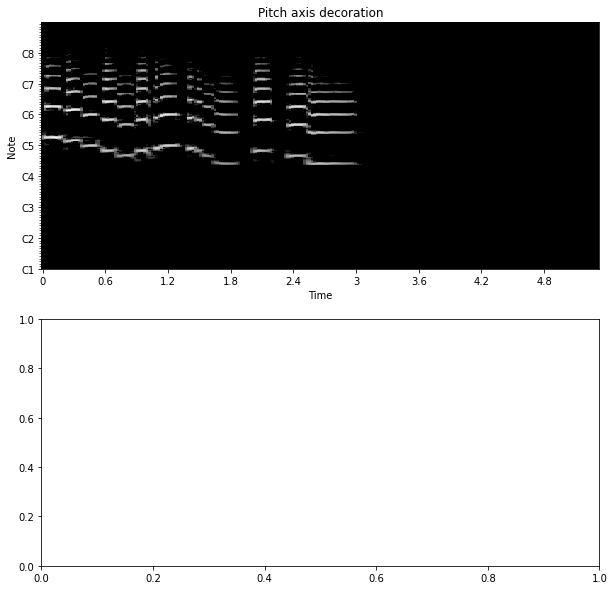

In [85]:
c_y = c_gray

fig, ax = plt.subplots(2,1,figsize=(10,10))
img = librosa.display.specshow(c_y, sr=sr, y_axis='cqt_note', x_axis='time', ax=ax[0], hop_length= hop_len, bins_per_octave= 12*freq_w, cmap='gray')
ax[0].set(title='Pitch axis decoration')
# fig.colorbar(img, ax=ax[0], format="%+2d dB")

ax[1].scatter(beat_times,dtempo)
ax[1].set_xlim(0,5)

In [57]:
src = c_gray

sharpening_mask1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpening_mask2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

sharpening_out1 = cv2.filter2D(src, -1, sharpening_mask1)
sharpening_out2 = cv2.filter2D(src, -1, sharpening_mask2)

cv2.imshow('sharpening1', sharpening_out1)
cv2.imshow('sharpening2', sharpening_out2)

cv2.waitKey()
cv2.destroyAllWindows()